# Imports

In [1]:
import matplotlib.pyplot as plt
import random as rd
from time import time
import seaborn as sns
import numpy as np
import pandas as pd

import numba as nb

sns.set(style="ticks", context="talk", rc={'figure.figsize':(12,10), 'figure.dpi':300})
plt.style.use("dark_background")

# Individual Class

In [2]:
@nb.njit
def check_fitness(size, flow_matrix, distance_matrix, genome):
    fitness = 0
    for i in range(size - 1):
        for j in range(i+1, size):
            fitness += flow_matrix[i][j] * distance_matrix[genome[i]][genome[j]]         
    return fitness*2

class Individual:
    def __init__(self, size, prob_mutation, mutation='swap', genome=[], random_genome=False, 
                 k=1, max_factor_scramble=0.5, problem='lipa20a'):
        self.size = size
        self.prob_mutation = prob_mutation
        self.mutation = mutation
        self.k = k
        self.problem = problem
        self.max_factor_scramble = max_factor_scramble
        self.flows = pd.read_csv(self.problem+'_flows.csv', header=None).to_numpy()
        self.distances = pd.read_csv(self.problem+'_distances.csv', header=None).to_numpy()
        if random_genome:
            self.genome = list(range(0, size))
            rd.shuffle(self.genome)
        else:
            self.genome = genome                                        
        
    def calculate_fitness(self):
        self.fitness = check_fitness(self.size, self.flows, self.distances, self.genome)
        
    def mutate(self):
        if rd.random() < self.prob_mutation:
            if self.mutation == 'swap':
                self.swap_mutation()
            elif self.mutation == 'kswap':
                self.kswap()
            elif self.mutation == 'scramble':
                self.scramble_mutation()
            elif self.mutation == 'inversion':
                self.inversion_mutation()
                
    def inversion_mutation(self):
        numbers = list(range(0, self.size))
        gens = rd.sample(numbers, k=2)
        gens.sort()
        selected_gens = self.genome[gens[0]:gens[1]]
        self.genome[gens[0]:gens[1]] = selected_gens[::-1]
            
    def scramble_mutation(self):
        factor = int(self.size*self.max_factor_scramble/2)
        numbers = list(range(factor-1, self.size-factor))
        gens = rd.sample(numbers, k=2)
        gens.sort()
        selected_gens = self.genome[gens[0]:gens[1]+1]
        rd.shuffle(selected_gens)
        self.genome[gens[0]:gens[1]+1] = selected_gens        
    
    def swap_mutation(self):
        numbers = list(range(0, self.size))
        gens = rd.sample(numbers, k=2)
        aux = self.genome[gens[0]]
        self.genome[gens[0]] = self.genome[gens[1]]
        self.genome[gens[1]] = aux
            
    def kswap(self):
        k = self.k
        for i in range(k):
            self.swap_mutation()
            
    def create_board(self):
        board = []
        for r in range(self.size):
            board += [[0] * self.size]
            board[r][self.genome[r]] = 1
        return board
            
    def print_board(self):
        board = self.create_board()
        for i in range(self.size):
            print(board[i])
            
    def __lt__(self, other):
        if self.fitness < other.fitness:
            return -1
        else:
            return 0
        
    def __radd__(self, other):
        return self.fitness + other

# Population Class

In [3]:
class Population:
    def __init__(self, size, size_genome, amount_parents_selection, prob_mutation, mutation='swap', 
                 crossover='cut_crossfill', k_crossover=1, k_mutation=1, max_factor_scramble=0.5, 
                 problem='lipa20a'):
        self.size = size
        self.size_genome = size_genome
        self.prob_mutation = prob_mutation
        self.amount_parents_selection = amount_parents_selection
        self.mutation = mutation
        self.type_crossover = crossover
        self.k_crossover = k_crossover
        self.k_mutation = k_mutation
        self.problem = problem
        self.max_factor_scramble = max_factor_scramble
        self.population = []
        for i in range(size):
            individual = Individual(size=size_genome, prob_mutation=prob_mutation, random_genome=True,
                                     mutation=mutation, k=k_mutation, 
                                     max_factor_scramble=max_factor_scramble, 
                                     problem=problem)
            individual.calculate_fitness()
            self.population.append(individual)
        self.population.sort()
        
    def statistics(self):        
        return self.population[0].fitness, sum(self.population)/self.size, self.population[-1].fitness
    
    def cut_crossfill(self, parent1, parent2):
        point = rd.randint(1, self.size_genome - 2)
        ch1_genome = self.do_crossover(parent1, parent2, point)
        ch2_genome = self.do_crossover(parent2, parent1, point)
        ch1 = Individual(size=self.size_genome, prob_mutation=self.prob_mutation, 
                         genome=ch1_genome, mutation=self.mutation, k=self.k_mutation, 
                         max_factor_scramble=self.max_factor_scramble, problem=self.problem)
        ch2 = Individual(size=self.size_genome, prob_mutation=self.prob_mutation, 
                         genome=ch2_genome, mutation=self.mutation, k=self.k_mutation, 
                         max_factor_scramble=self.max_factor_scramble, problem=self.problem)
        return ch1, ch2        
    
    def cicle_crossover(self, parent1, parent2):
        d1 = {}
        d2 = {}
        for i in range(self.size_genome):
            if i not in d1:
                if i % 2 == 0:
                    d1t, d2t = self.do_cicles(parent1, parent2, i)
                    
                else:
                    d2t, d1t = self.do_cicles(parent1, parent2, i)
                d1 = dict(list(d1.items()) + list(d1t.items()))
                d2 = dict(list(d2.items()) + list(d2t.items()))
        ch1_genome = [0]*self.size_genome
        ch2_genome = [0]*self.size_genome
        for pos in range(self.size_genome):
            ch1_genome[pos] = d1[pos]
            ch2_genome[pos] = d2[pos]
        ch1 = Individual(size=self.size_genome, prob_mutation=self.prob_mutation, 
                         genome=ch1_genome, mutation=self.mutation, k=self.k_mutation, 
                         max_factor_scramble=self.max_factor_scramble, problem=self.problem)
        ch2 = Individual(size=self.size_genome, prob_mutation=self.prob_mutation, 
                         genome=ch2_genome, mutation=self.mutation, k=self.k_mutation, 
                         max_factor_scramble=self.max_factor_scramble, problem=self.problem)
        return ch1, ch2
        
    def do_cicles(self, parent1, parent2, start):
        d1 = {}
        d2 = {}
        i = start
        flag = False
        while not flag:
            d1[i] = parent1[i]
            pos = parent2.index(parent1[i])
            d2[pos] = parent1[i]
            i = parent1.index(parent1[pos])
            if i == start:
                flag = True
        return d1, d2
    
    def crossover(self, parent1, parent2):
        if self.type_crossover == 'cut_crossfill':
            return self.cut_crossfill(parent1, parent2)
        elif self.type_crossover == 'cicle':
            return self.cicle_crossover(parent1, parent2)
        elif self.type_crossover == 'uniform':
            return self.uniform_crossover(parent1, parent2)
        elif self.type_crossover == 'ox1':
            return self.order_crossover_operator(parent1, parent2)

    def order_crossover_operator(self, parent1, parent2):
        point = rd.randint(1, self.size_genome - 2)
        ch1_genome = [-1] * self.size_genome
        ch2_genome = [-1] * self.size_genome

        for i in range(self.k_crossover):
            k = (point + i) % self.size_genome
            if parent1[k] not in ch1_genome:
                ch1_genome[k] = parent1[k]
            if parent2[k] not in ch2_genome:
                ch2_genome[k] = parent2[k]

        k = point + self.k_crossover
        j = k % self.size_genome
        l = self.k_crossover
        while l < self.size_genome:
            k = k % self.size_genome
            if parent2[k] not in ch1_genome:
                ch1_genome[j] = parent2[k]
                j = (j + 1) % self.size_genome
                l += 1
            k += 1

        k = point + self.k_crossover
        j = k % self.size_genome
        l = self.k_crossover
        while l < self.size_genome:
            k = k % self.size_genome
            if parent1[k] not in ch2_genome:
                ch2_genome[j] = parent1[k]
                j = (j + 1) % self.size_genome
                l += 1
            k += 1

        ch1 = Individual(size=self.size_genome, prob_mutation=self.prob_mutation, 
                         genome=ch1_genome, mutation=self.mutation, k=self.k_mutation, 
                         max_factor_scramble=self.max_factor_scramble, problem=self.problem)
        ch2 = Individual(size=self.size_genome, prob_mutation=self.prob_mutation, 
                         genome=ch2_genome, mutation=self.mutation, k=self.k_mutation, 
                         max_factor_scramble=self.max_factor_scramble, problem=self.problem)
        return ch1, ch2

    def uniform_crossover(self, parent1, parent2):
        ch1_genome = []
        ch2_genome = []
        
        i = 0
        while len(ch1_genome) < self.size_genome or len(ch2_genome) < self.size_genome:
            if rd.random() <= 0.5:
                if len(ch1_genome) < self.size_genome and parent1[i] not in ch1_genome:
                    ch1_genome.append(parent1[i])
                if len(ch2_genome) < self.size_genome and parent2[i] not in ch2_genome:
                    ch2_genome.append(parent2[i])
            else:
                if len(ch1_genome) < self.size_genome and parent2[i] not in ch1_genome:
                    ch1_genome.append(parent2[i])
                if len(ch2_genome) < self.size_genome and parent1[i] not in ch2_genome:
                    ch2_genome.append(parent1[i])
                    
            i = (i + 1) % self.size_genome

        ch1 = Individual(size=self.size_genome, prob_mutation=self.prob_mutation, 
                         genome=ch1_genome, mutation=self.mutation, k=self.k_mutation, 
                         max_factor_scramble=self.max_factor_scramble, problem=self.problem)
        ch2 = Individual(size=self.size_genome, prob_mutation=self.prob_mutation, 
                         genome=ch2_genome, mutation=self.mutation, k=self.k_mutation, 
                         max_factor_scramble=self.max_factor_scramble, problem=self.problem)
        return ch1, ch2
           
    def do_crossover(self, parent1, parent2, point):
        k = point
        ch_genome = parent1[:point]
        while len(ch_genome) < self.size_genome:
            k = k % self.size_genome
            if parent2[k] not in ch_genome:
                ch_genome.append(parent2[k])
            k += 1
        return ch_genome
                        
    def parents_selection(self, amount_random_selection):
        selected = rd.sample(self.population, k=amount_random_selection)
        selected.sort()
        ch1, ch2 = self.crossover(selected[0].genome, selected[1].genome)
        ch1.mutate()
        ch2.mutate()
        return ch1, ch2
    
    def survivors_selection(self):
        ch1, ch2 = self.parents_selection(self.amount_parents_selection)
        children = [ch1, ch2]
        i = 0
        pop = self.population[::-1]
        for child in children:
            child.calculate_fitness()
            if child.fitness < pop[i].fitness:
                self.replacement_poblation(child, i)
            i += 1
        self.population.sort()
        
    def replacement_poblation(self, new_child, pos):
        self.population[self.size-1-pos] = new_child
    
    def get_best_individual(self):
        return self.population[0]
            

# Evolutionary Algorithm Class

In [4]:
class Evolutionary_Algorithm:
    def __init__(self, size_population, size_genome, prob_mutation, amount_parents_selection, 
                 generations, target_fitness, prob_recombination, mutation='swap', 
                 crossover='cut_crossfill', k_crossover=1, k_mutation=1, max_factor_scramble=0.25, 
                 problem='lipa20a'):
        self.size_population = size_population
        self.size_genome = size_genome
        self.prob_mutation = prob_mutation
        self.amount_parents_selection = amount_parents_selection
        self.generations = generations
        self.target_fitness = target_fitness
        self.prob_recombination = prob_recombination
        self.current_generation = 1
        self.mutation = mutation
        self.crossover = crossover
        self.k_crossover = k_crossover
        self.k_mutation = k_mutation
        self.problem = problem
        self.max_factor_scramble = max_factor_scramble
        
    def initialize_population(self):
        population = Population(size=self.size_population, size_genome=self.size_genome, 
                              amount_parents_selection=self.amount_parents_selection,
                              prob_mutation=self.prob_mutation, mutation=self.mutation, 
                              crossover=self.crossover, k_crossover=self.k_crossover, 
                              k_mutation=self.k_mutation, max_factor_scramble=self.max_factor_scramble, 
                              problem=self.problem)
        self.current_fitness_evaluations = self.size_population
        best_fitness, mean_fitness, worst_fitness = population.statistics()
        self.best_pop_fitness_per_gen = [best_fitness]
        self.mean_pop_fitness_per_gen = [mean_fitness]
        self.worst_pop_fitness_per_gen = [worst_fitness]
        return population
        
    def fit(self):
        population = self.initialize_population()
        while(self.current_generation < self.generations and 
              self.best_pop_fitness_per_gen[-1] > self.target_fitness):
            k = int((self.size_population*self.prob_recombination/self.amount_parents_selection))
            for i in range(k):
                population.survivors_selection()
                self.current_fitness_evaluations += 2
            self.current_generation += 1
            best_fitness, mean_fitness, worst_fitness = population.statistics()
            self.best_pop_fitness_per_gen.append(best_fitness)
            self.worst_pop_fitness_per_gen.append(worst_fitness)
            self.mean_pop_fitness_per_gen.append(mean_fitness)
        
        self.best_individual = population.get_best_individual()
        
    def summary(self):
        print('Fitness Evaluations:', self.current_fitness_evaluations)
        print('Generations:', self.current_generation)
        print('Best individual with', self.best_individual.fitness,'fitness')
        print('Mean individual in last generation with', int(self.mean_pop_fitness_per_gen[-1]),'fitness')
        
    def print_solution(self):
        self.best_individual.print_board()
        
    def technical_summary(self):
        print('Representations: Pemutations')
        print('Recombination:', self.crossover, 'crossover')
        print('Recombination probability:', self.prob_recombination*100, '%')
        print('Mutation:', self.mutation)
        print('Mutation probability:', self.prob_mutation*100, '%')
        print('Parent selection: Best 2 of random', self.amount_parents_selection)
        print('Survival selection: Replace worst')
        print('Number of Offspring: 2')
        print('Initialisation: Random')
        print('Termination condition: Solution or', self.generations, 'generations')
        
    def history_gen_plot(self):
        x = list(range(1,self.current_generation+1))
        plt.plot(x, self.best_pop_fitness_per_gen, 'g', label='Best Fitness')
        plt.plot(x, self.mean_pop_fitness_per_gen, 'darkcyan', label='Mean Fitness')
        plt.plot(x, self.worst_pop_fitness_per_gen, 'r', label='Worst Fitness')
        plt.legend()
        plt.xlabel('Generations')
        plt.ylabel('Fitness')
        plt.show()
        
    def save_solution(self, file):
        f = open(file, 'a+')
        f.write(str(self.best_individual.genome) + '\n')
        f.write(str(self.best_individual.fitness) + '\n\n')
        f.close()

# Model

Representations: Pemutations
Recombination: ox1 crossover
Recombination probability: 100.0 %
Mutation: swap
Mutation probability: 80.0 %
Parent selection: Best 2 of random 5
Survival selection: Replace worst
Number of Offspring: 2
Initialisation: Random
Termination condition: Solution or 1000 generations

Elapsed time: 138.3069 seconds.
Fitness Evaluations: 40060
Generations: 1000
Best individual with 247868 fitness
Mean individual in last generation with 248188 fitness


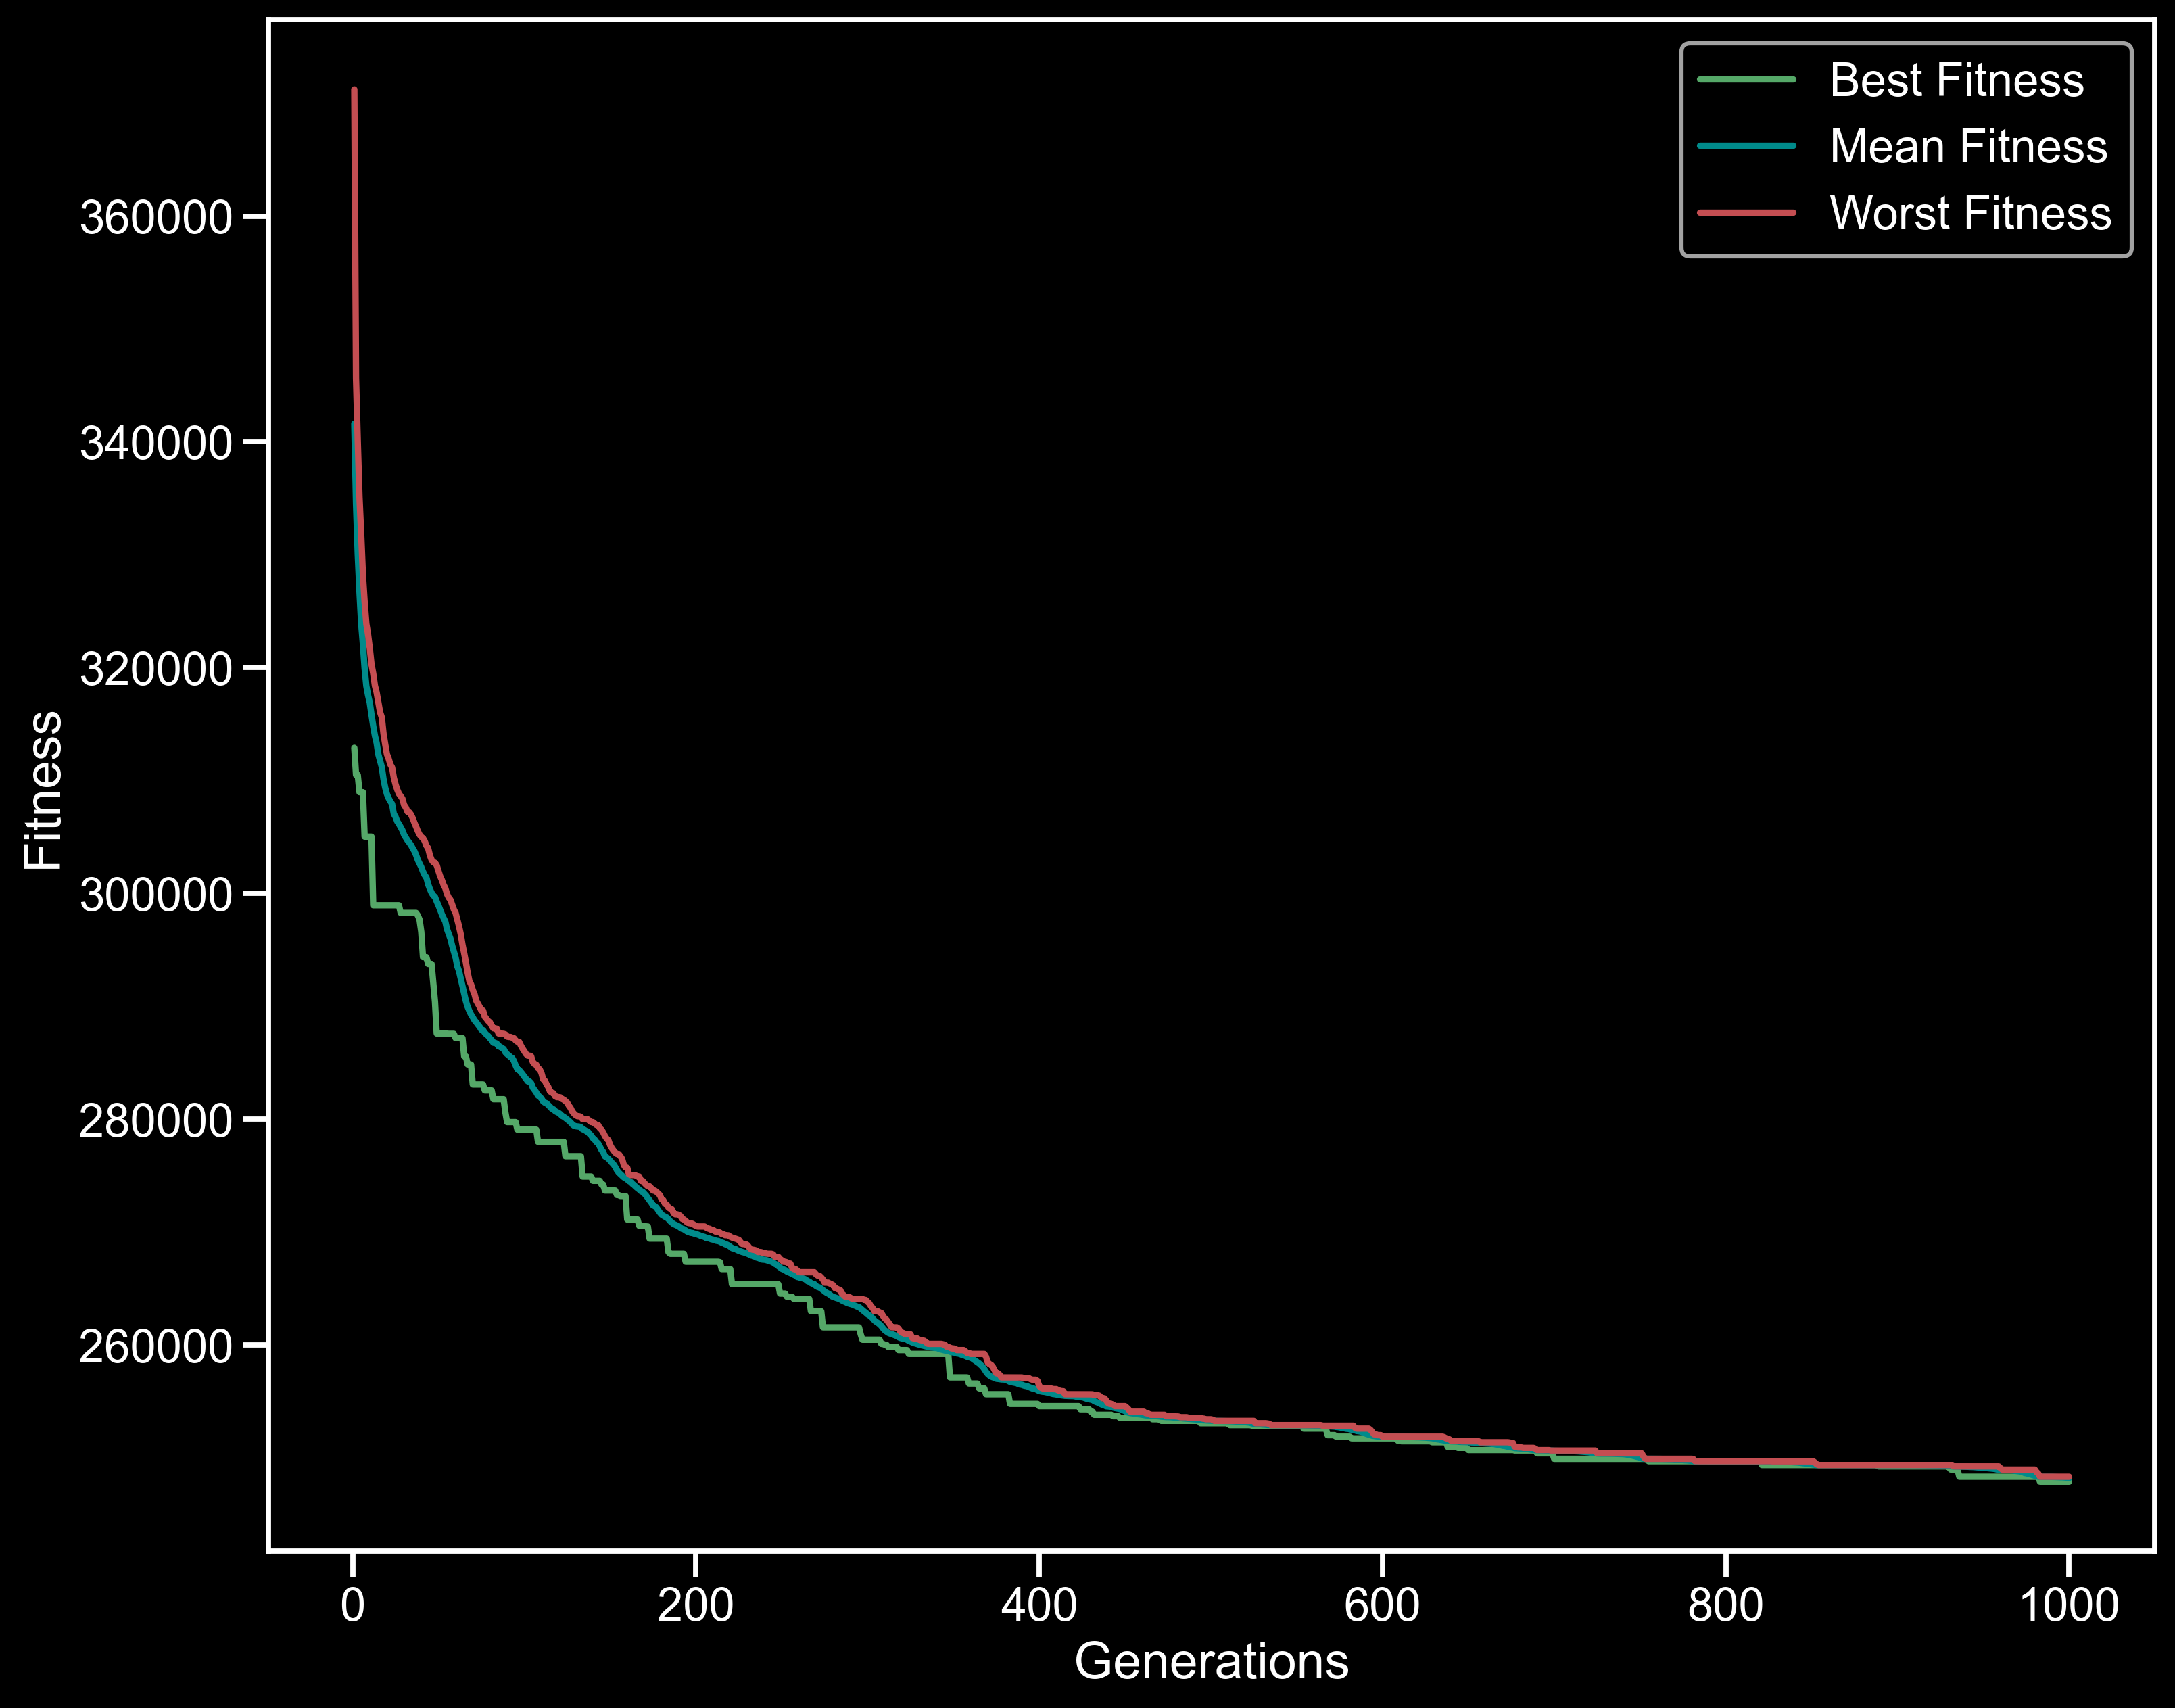

In [30]:
model = Evolutionary_Algorithm(size_population=100, size_genome=40, 
                               prob_mutation=0.8,
                               amount_parents_selection=5, generations=1000, 
                               target_fitness=0, prob_recombination=1.0, mutation='swap',
                               crossover='ox1', k_crossover=30, k_mutation=8, 
                               max_factor_scramble=0.25, problem='tho40')
model.technical_summary()

start_time = time()
model.fit()
elapsed_time = time() - start_time
print("\nElapsed time: %.4f seconds." % elapsed_time)

model.summary()
model.history_gen_plot()

# Run 10 times by 8 models

In [6]:
crossovers = ['cut_crossfill', 'cicle', 'uniform', 'ox1']
mutations = ['swap', 'kswap']
iterations = 10
time_dict = {}
fitness_dict = {}
for cross in crossovers:
    for mut in mutations:
        time_dict[cross + ' - ' + mut] = []
        fitness_dict[cross + ' - ' + mut] = []
        for i in range(iterations):
            model = Evolutionary_Algorithm(size_population=100, size_genome=20, 
                                           prob_mutation=0.8,
                                           amount_parents_selection=5, generations=300, 
                                           target_fitness=0, prob_recombination=1.0, mutation=mut,
                                           crossover=cross, k_crossover=15, k_mutation=5, 
                                           max_factor_scramble=0.25, problem='lipa20a')
            start_time = time()
            model.fit()
            elapsed_time = time() - start_time
            #model.save_solution('solutions.txt')
            time_dict[cross + ' - ' + mut].append(elapsed_time)
            fitness_dict[cross + ' - ' + mut].append(model.best_individual.fitness)

C:\Users\Taiko\AppData\Roaming\Python\Python38\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'genome' of function 'check_fitness'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-2-5fa5c15757d2>", line 2:
@nb.njit
def check_fitness(size, flow_matrix, distance_matrix, genome):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [7]:
d = {}
for cross in crossovers:
    for mut in mutations:
        k = cross + ' - ' + mut
        d[k] = {}
        d[k]['max_time'] = max(time_dict[k])
        d[k]['min_time'] = min(time_dict[k])
        d[k]['mean_time'] = sum(time_dict[k])/iterations
        d[k]['std_time'] = np.std(time_dict[k])
        d[k]['mean_fitness'] = sum(fitness_dict[k])/iterations
        d[k]['std_fitness'] = np.std(fitness_dict[k])
        d[k]['best_fitness'] = min(fitness_dict[k])
        d[k]['worst_fitness'] = max(fitness_dict[k])

<AxesSubplot:xlabel='mean_time', ylabel='mean_fitness'>

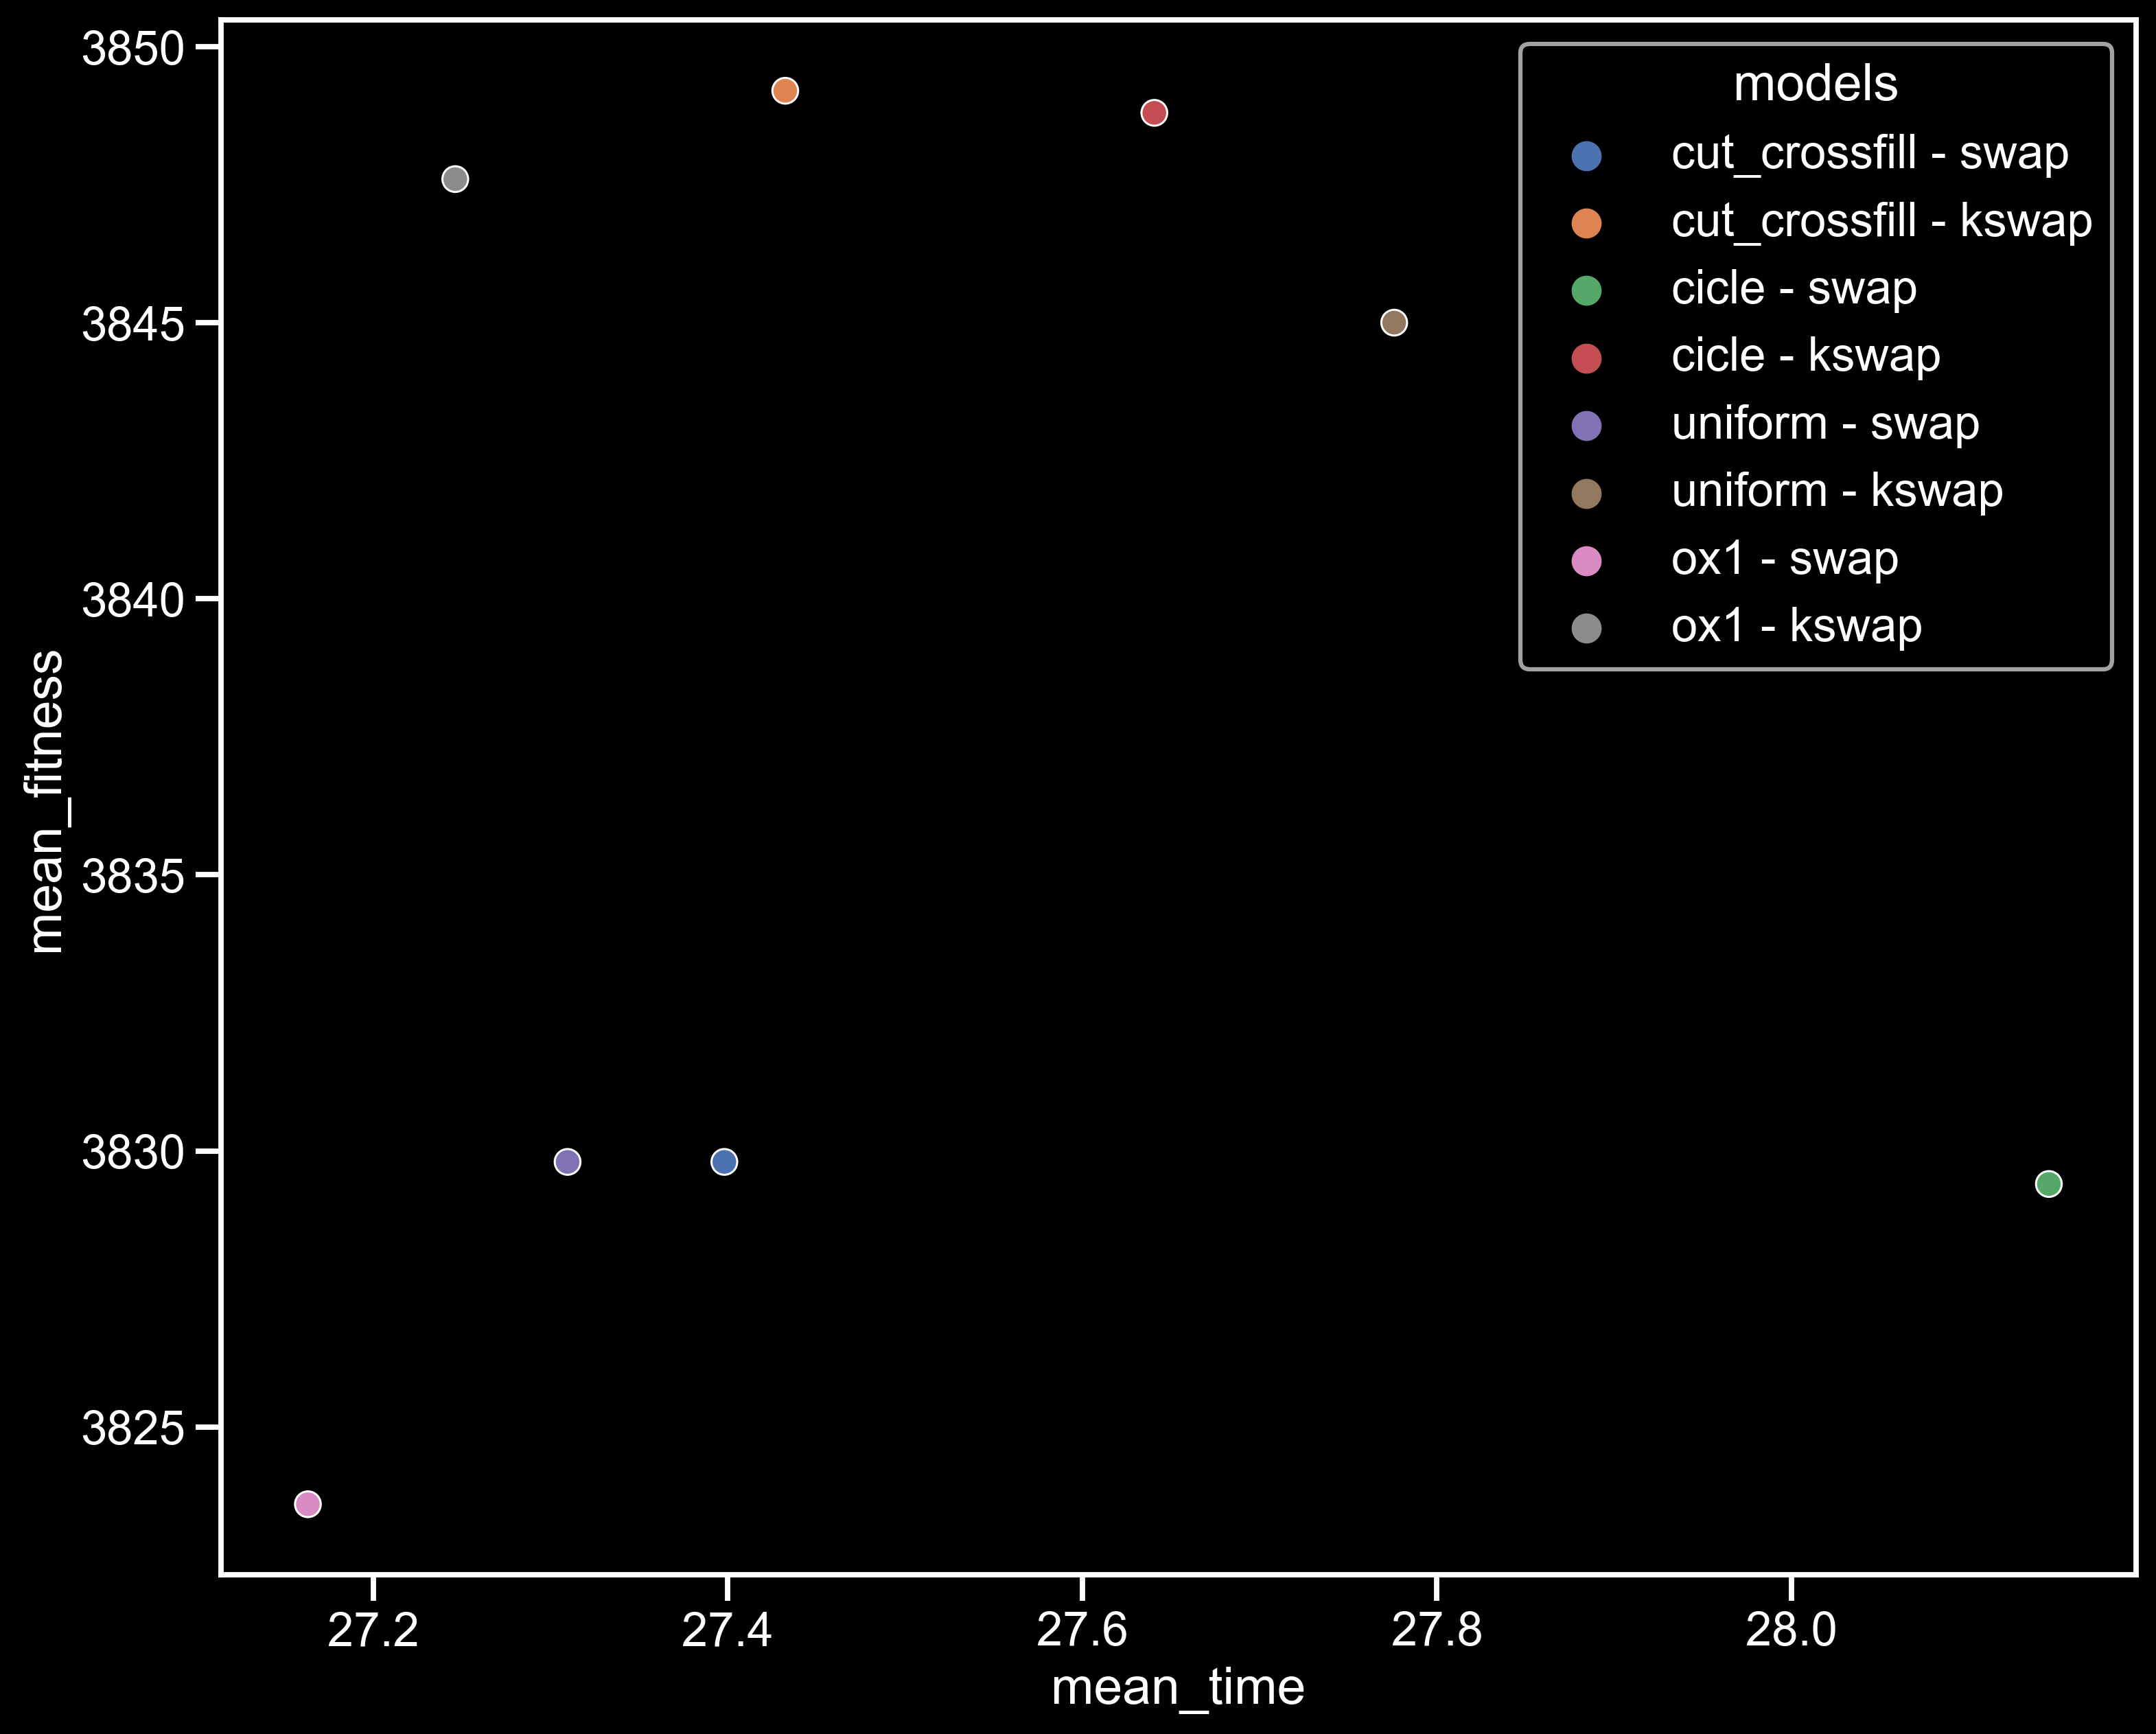

In [18]:
data = {'mean_time': [], 'mean_fitness':[], 'models': list(d.keys())}
for m in list(d.keys()):
    data['mean_time'].append(d[m]['mean_time'])
    data['mean_fitness'].append(d[m]['mean_fitness'])
    
sns.scatterplot(x='mean_time', y='mean_fitness', data=data, hue='models', legend=True, palette='deep')
#plt.legend(labels=data['models'], loc = 2, bbox_to_anchor = (1,1))

# Run 30 times model selected for lipa20a
* OX1 - Swap - 250 generations

In [22]:
crossovers = ['ox1']
mutations = ['swap']
iterations = 30
time_dict = {}
fitness_dict = {}
for cross in crossovers:
    for mut in mutations:
        time_dict[cross + ' - ' + mut] = []
        fitness_dict[cross + ' - ' + mut] = []
        for i in range(iterations):
            model = Evolutionary_Algorithm(size_population=100, size_genome=20, 
                                           prob_mutation=0.8,
                                           amount_parents_selection=5, generations=250, 
                                           target_fitness=0, prob_recombination=1.0, mutation=mut,
                                           crossover=cross, k_crossover=15, k_mutation=5, 
                                           max_factor_scramble=0.25, problem='lipa20a')
            start_time = time()
            model.fit()
            elapsed_time = time() - start_time
            model.save_solution('solutions_lipa20a.txt')
            time_dict[cross + ' - ' + mut].append(elapsed_time)
            fitness_dict[cross + ' - ' + mut].append(model.best_individual.fitness)

In [23]:
d = {}
for cross in crossovers:
    for mut in mutations:
        k = cross + ' - ' + mut
        d[k] = {}
        d[k]['max_time'] = max(time_dict[k])
        d[k]['min_time'] = min(time_dict[k])
        d[k]['mean_time'] = sum(time_dict[k])/iterations
        d[k]['std_time'] = np.std(time_dict[k])
        d[k]['mean_fitness'] = sum(fitness_dict[k])/iterations
        d[k]['std_fitness'] = np.std(fitness_dict[k])
        d[k]['best_fitness'] = min(fitness_dict[k])
        d[k]['worst_fitness'] = max(fitness_dict[k])
        
data = pd.DataFrame(d)
data.head(8)

,ox1 - swap
best_fitness,3806.000000
max_time,23.988115
mean_fitness,3830.800000
mean_time,23.484532
min_time,23.382094
std_fitness,10.678327
std_time,0.143284
worst_fitness,3856.000000


# Run 30 times model selected for kra30a
* OX1 - Swap - 500 generations

In [27]:
crossovers = ['ox1']
mutations = ['swap']
iterations = 30
time_dict = {}
fitness_dict = {}
for cross in crossovers:
    for mut in mutations:
        time_dict[cross + ' - ' + mut] = []
        fitness_dict[cross + ' - ' + mut] = []
        for i in range(iterations):
            model = Evolutionary_Algorithm(size_population=100, size_genome=30, 
                                           prob_mutation=0.8,
                                           amount_parents_selection=5, generations=500, 
                                           target_fitness=0, prob_recombination=1.0, mutation=mut,
                                           crossover=cross, k_crossover=22, k_mutation=8, 
                                           max_factor_scramble=0.25, problem='kra30a')
            start_time = time()
            model.fit()
            elapsed_time = time() - start_time
            model.save_solution('solutions_kra30a.txt')
            time_dict[cross + ' - ' + mut].append(elapsed_time)
            fitness_dict[cross + ' - ' + mut].append(model.best_individual.fitness)

In [28]:
d = {}
for cross in crossovers:
    for mut in mutations:
        k = cross + ' - ' + mut
        d[k] = {}
        d[k]['max_time'] = max(time_dict[k])
        d[k]['min_time'] = min(time_dict[k])
        d[k]['mean_time'] = sum(time_dict[k])/iterations
        d[k]['std_time'] = np.std(time_dict[k])
        d[k]['mean_fitness'] = sum(fitness_dict[k])/iterations
        d[k]['std_fitness'] = np.std(fitness_dict[k])
        d[k]['best_fitness'] = min(fitness_dict[k])
        d[k]['worst_fitness'] = max(fitness_dict[k])
        
data = pd.DataFrame(d)
data.head(8)

,ox1 - swap
best_fitness,92060.000000
max_time,57.853720
mean_fitness,94998.333333
mean_time,57.245463
min_time,56.996982
std_fitness,1460.066399
std_time,0.164849
worst_fitness,98420.000000


# Run 30 times model selected for tai35b
* OX1 - Swap - 500 generations

In [32]:
crossovers = ['ox1']
mutations = ['swap']
iterations = 30
time_dict = {}
fitness_dict = {}
for cross in crossovers:
    for mut in mutations:
        time_dict[cross + ' - ' + mut] = []
        fitness_dict[cross + ' - ' + mut] = []
        for i in range(iterations):
            model = Evolutionary_Algorithm(size_population=100, size_genome=35, 
                                           prob_mutation=0.8,
                                           amount_parents_selection=5, generations=500, 
                                           target_fitness=0, prob_recombination=1.0, mutation=mut,
                                           crossover=cross, k_crossover=26, k_mutation=9, 
                                           max_factor_scramble=0.25, problem='tai35b')
            start_time = time()
            model.fit()
            elapsed_time = time() - start_time
            model.save_solution('solutions_tai35b.txt')
            time_dict[cross + ' - ' + mut].append(elapsed_time)
            fitness_dict[cross + ' - ' + mut].append(model.best_individual.fitness)

In [33]:
d = {}
for cross in crossovers:
    for mut in mutations:
        k = cross + ' - ' + mut
        d[k] = {}
        d[k]['max_time'] = max(time_dict[k])
        d[k]['min_time'] = min(time_dict[k])
        d[k]['mean_time'] = sum(time_dict[k])/iterations
        d[k]['std_time'] = np.std(time_dict[k])
        d[k]['mean_fitness'] = sum(fitness_dict[k])/iterations
        d[k]['std_fitness'] = np.std(fitness_dict[k])
        d[k]['best_fitness'] = min(fitness_dict[k])
        d[k]['worst_fitness'] = max(fitness_dict[k])
        
data = pd.DataFrame(d)
data.head(8)

,ox1 - swap
best_fitness,1.608886e+08
max_time,6.451194e+01
mean_fitness,1.726717e+08
mean_time,6.329585e+01
min_time,6.298513e+01
std_fitness,7.819222e+06
std_time,3.359301e-01
worst_fitness,1.873438e+08


# Run 30 times model selected for tho40
* OX1 - Swap - 1000 generations

In [34]:
crossovers = ['ox1']
mutations = ['swap']
iterations = 30
time_dict = {}
fitness_dict = {}
for cross in crossovers:
    for mut in mutations:
        time_dict[cross + ' - ' + mut] = []
        fitness_dict[cross + ' - ' + mut] = []
        for i in range(iterations):
            model = Evolutionary_Algorithm(size_population=100, size_genome=40, 
                                           prob_mutation=0.8,
                                           amount_parents_selection=5, generations=1000, 
                                           target_fitness=0, prob_recombination=1.0, mutation=mut,
                                           crossover=cross, k_crossover=30, k_mutation=9, 
                                           max_factor_scramble=0.25, problem='tho40')
            start_time = time()
            model.fit()
            elapsed_time = time() - start_time
            model.save_solution('solutions_tho40.txt')
            time_dict[cross + ' - ' + mut].append(elapsed_time)
            fitness_dict[cross + ' - ' + mut].append(model.best_individual.fitness)

In [35]:
d = {}
for cross in crossovers:
    for mut in mutations:
        k = cross + ' - ' + mut
        d[k] = {}
        d[k]['max_time'] = max(time_dict[k])
        d[k]['min_time'] = min(time_dict[k])
        d[k]['mean_time'] = sum(time_dict[k])/iterations
        d[k]['std_time'] = np.std(time_dict[k])
        d[k]['mean_fitness'] = sum(fitness_dict[k])/iterations
        d[k]['std_fitness'] = np.std(fitness_dict[k])
        d[k]['best_fitness'] = min(fitness_dict[k])
        d[k]['worst_fitness'] = max(fitness_dict[k])
        
data = pd.DataFrame(d)
data.head(8)

,ox1 - swap
best_fitness,243088.000000
max_time,137.821441
mean_fitness,250807.866667
mean_time,136.957233
min_time,136.614404
std_fitness,3270.599290
std_time,0.252955
worst_fitness,257574.000000
